In [1]:
import numpy as np
import os
import sys
import warnings
import time

# Define paths to relevant modules
measure_sampling_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Measure_sampling"
)
trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Trees"
)
Benchmark_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/Benchmark_value_Gausian"
)
awd_trees_path = os.path.abspath(
    "/Users/rubenbontorno/Documents/Master_Thesis/Code/AWD_numerics/AWD_trees"
)

# Add paths to sys.path
for path in [measure_sampling_path, trees_path, Benchmark_path, awd_trees_path]:
    if path not in sys.path:
        sys.path.append(path)

# Import necessary modules
from Gen_Path_and_AdaptedTrees import generate_adapted_tree
from Tree_Node import *
from TreeAnalysis import *
from TreeVisualization import *
from Save_Load_trees import *
from Tree_AWD_utilities import *
from Comp_AWD2_Gaussian import build_mean_and_cov, adapted_wasserstein_squared
from Gurobi_AOT import *
from Nested_Dist_Algo import compute_nested_distance

# Suppress sklearn warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Running 1/10 for sample size 200...
Running 2/10 for sample size 200...
Running 3/10 for sample size 200...
Running 4/10 for sample size 200...
Running 5/10 for sample size 200...
Running 6/10 for sample size 200...
Running 7/10 for sample size 200...
Running 8/10 for sample size 200...
Running 9/10 for sample size 200...
Running 10/10 for sample size 200...
Running 1/10 for sample size 500...
Running 2/10 for sample size 500...
Running 3/10 for sample size 500...
Running 4/10 for sample size 500...
Running 5/10 for sample size 500...
Running 6/10 for sample size 500...
Running 7/10 for sample size 500...
Running 8/10 for sample size 500...
Running 9/10 for sample size 500...
Running 10/10 for sample size 500...
Running 1/10 for sample size 1000...
Running 2/10 for sample size 1000...
Running 3/10 for sample size 1000...
Running 4/10 for sample size 1000...
Running 5/10 for sample size 1000...
Running 6/10 for sample size 1000...
Running 7/10 for sample size 1000...
Running 8/10 for sa

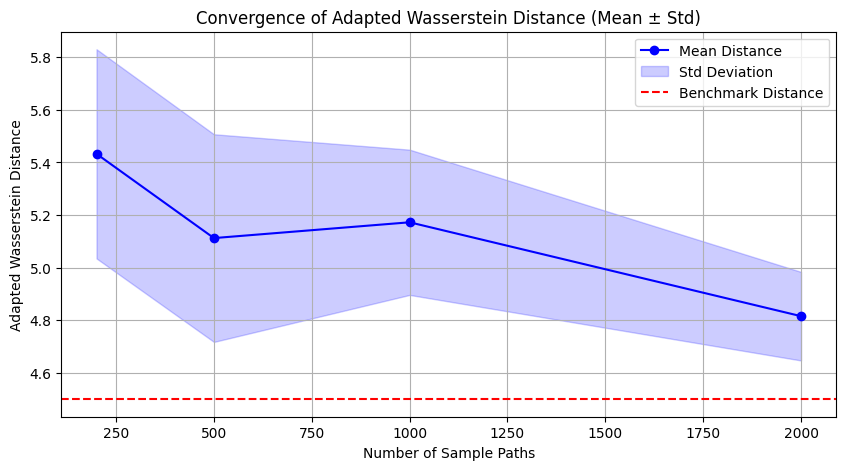

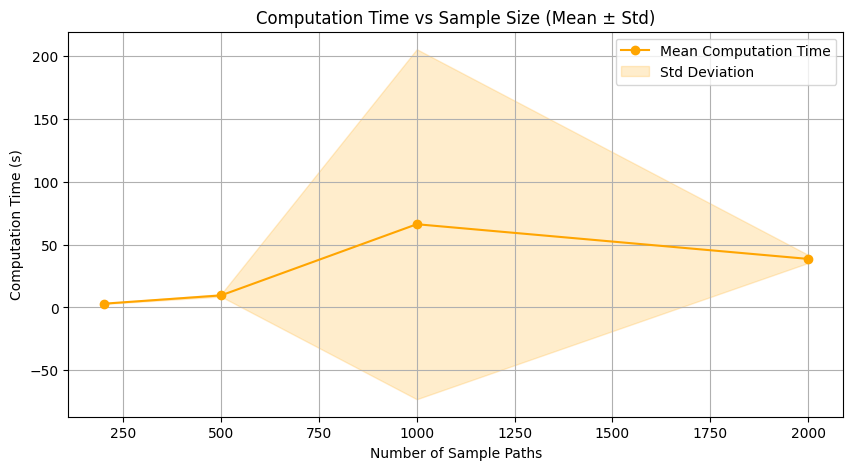

In [2]:
import random
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Define parameters
sample_sizes = [200, 500, 1000, 2000]  # Increasing sample sizes
time_steps = 4  # Number of time steps per path
scale1 = 1
scale2 = 0.5
init_a, init_b = 1, 2
use_weights = 1

# Number of runs per sample size
n_runs = 10

# Arrays to store results across runs
distances_all = np.zeros((len(sample_sizes), n_runs))
times_all = np.zeros((len(sample_sizes), n_runs))

# Compute benchmark adapted Wasserstein distance once
t = time_steps - 1
a_vec, A_mat = build_mean_and_cov(t, mean_val=init_a, var_factor=scale1**2)
b_vec, B_mat = build_mean_and_cov(t, mean_val=init_b, var_factor=scale2**2)
distance_squared = adapted_wasserstein_squared(a_vec, A_mat, b_vec, B_mat)

# Main loop over sample sizes
for i, num_paths in enumerate(sample_sizes):
    for run_idx in range(n_runs):
        print(f"Running {run_idx+1}/{n_runs} for sample size {num_paths}...")

        # Generate adapted trees
        bm1_root, _ = generate_adapted_tree(
            num_paths=num_paths,
            time_steps=time_steps,
            x_init=init_a,
            scale=scale1,
            use_weights=use_weights,
            model="brownian",
            return_times=True,
            cluster_method="kmeans_grid",
        )

        bm2_root, _ = generate_adapted_tree(
            num_paths=num_paths,
            time_steps=time_steps,
            x_init=init_b,
            scale=scale2,
            use_weights=use_weights,
            model="brownian",
            return_times=True,
            cluster_method="kmeans_grid",
        )

        # Compute adapted optimal transport distance
        max_depth = get_depth(bm1_root)
        start_time = time.time()
        distance_pot = compute_nested_distance(
            bm1_root,
            bm2_root,
            max_depth,
            method="solver_lp_pot",
            return_matrix=False,
            lambda_reg=0,
            power=2,
        )
        elapsed_time_pot = time.time() - start_time

        # Adjust distance (subtract initial difference in squares if needed)
        distance_pot -= (init_a - init_b) ** 2

        # Store results
        distances_all[i, run_idx] = distance_pot
        times_all[i, run_idx] = elapsed_time_pot

# After collecting data for all runs, compute statistics
distances_mean = distances_all.mean(axis=1)
distances_std = distances_all.std(axis=1)
times_mean = times_all.mean(axis=1)
times_std = times_all.std(axis=1)

# ---------------------------------------------------------
# PLOT 1: Distance convergence with mean ± std band
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

# Mean distance
plt.plot(sample_sizes, distances_mean, label="Mean Distance", marker="o", color="blue")

# Fill between mean ± std
plt.fill_between(
    sample_sizes,
    distances_mean - distances_std,
    distances_mean + distances_std,
    alpha=0.2,
    color="blue",
    label="Std Deviation",
)

# Benchmark line
plt.axhline(y=distance_squared, color="r", linestyle="--", label="Benchmark Distance")

plt.xlabel("Number of Sample Paths")
plt.ylabel("Adapted Wasserstein Distance")
plt.title("Convergence of Adapted Wasserstein Distance (Mean ± Std)")
plt.legend()
plt.grid()
plt.show()

# ---------------------------------------------------------
# PLOT 2: Computation time with mean ± std band
# ---------------------------------------------------------
plt.figure(figsize=(10, 5))

# Mean time
plt.plot(
    sample_sizes, times_mean, label="Mean Computation Time", marker="o", color="orange"
)

# Fill between mean ± std
plt.fill_between(
    sample_sizes,
    times_mean - times_std,
    times_mean + times_std,
    alpha=0.2,
    color="orange",
    label="Std Deviation",
)

plt.xlabel("Number of Sample Paths")
plt.ylabel("Computation Time (s)")
plt.title("Computation Time vs Sample Size (Mean ± Std)")
plt.legend()
plt.grid()
plt.show()